# Memtables, Joins and, Selectors (and 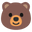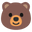)! Oh my!

## Memtables

`ibis.memtable` is a convenient way to take data you already have in-memory and use it within one of the Ibis backends.

**Note**: for very large tables, there are performance implications depending on the backend you use.

In [ ]:
import ibis
import pandas as pd
import pyarrow as pa

In [ ]:
ibis.options.interactive = True

In [ ]:
plain_dict = {
    "name": ["Gil", "Phillip", "Jim", "Krisztián", "Wes"],
    "committed": [176, 2680, 158, 288, 387],
    "aliases": [
        "Schemata Eldritch",
        "Chuckles",
        "Minnesota Fats",
        "Szűcs",
        "Goldeneye",
    ],
}
pat = pa.Table.from_pydict(
    {
        "name": ["Gil", "Phillip", "Jim", "Krisztián", "Wes"],
        "pickleCount": [9.22, 5.123, 6.242, 22.47, None],
    },
)

df = pd.DataFrame(
    {
        "name": ["Gil", "Phillip", "Jim", "Krisztián", "Wes"],
        "committed": [True, True, True, True, True],
        "first_commit": [
            "b0f4f44a1",
            "2cd935599",
            "67037d099",
            "3324d1f2d",
            "84d043583",
        ],
    }
)

You can construct a memtable from a dictionary, a Pandas DataFrame, or a PyArrow Table

In [ ]:
t1 = ibis.memtable(plain_dict)
t2 = ibis.memtable(pat)
t3 = ibis.memtable(df)

In [ ]:
t1

In [ ]:
print(pat.schema)
t2

In [ ]:
print(df.dtypes)
t3

If a `memtable` is created from a plain dictionary (or if a `pandas.Series` is of `object` dtype), `ibis` will infer the dtype. Well-typed columns will have their datatypes preserved (modulo some possible small name differences, e.g. `uint` vs. `uinteger`)

In [ ]:
pat = pat.cast(
    pa.schema(
        [
            ("name", pa.string()),
            ("pickleCount", pa.decimal128(16, 3)),
        ]
    )
)

In [ ]:
t2 = ibis.memtable(pat)

In [ ]:
t2

## Joins

Many interesting datasets (and also boring ones!) are stored in separate tables.  To perform analysis on these data, we have to join the separate tables togther.

Let's start with some Ibis maintainer data:

In [ ]:
t1.join(t2, "name")

By default, we perform an inner join.  If the join column has the same name in both tables, you can pass in the column name as a string.

If they are different, or you care to specify it, you can also provide the columns more explicitly:

In [ ]:
t1.join(t2, t1.name == t2.name)

### Name collisions

If the tables share more than just the join column in common, Ibis will rename columns as needed:

In [ ]:
t1.join(t3, "name")

But you can also specify different naming schemes:

In [ ]:
t1.join(t3, "name", lname="{name}_left")

In [ ]:
t1.join(t3, "name", rname="right_{name}")

### Other Joins

The default join in Ibis is an inner-join, but you can specify several other types of join using the `how` keyword:

In [ ]:
t1.join(t3, t1.name == t3.first_commit, how="outer")

There are also join-specific methods for each type of join:

In [ ]:
t1.outer_join(t3, t1.name == t3.first_commit)

### Chaining Joins

You can also chain multiple joins, for instance:

In [ ]:
t1.join(t2, "name").join(t3, "name")

## Deferred operator

Let's consider again the output of one of the joins above:

In [ ]:
t1.join(t3, "name")

Let's say we want to filter on the contents of the `committed_right` column (admittedly, a bit silly, since it is all `True`) -- how do we refer to that column?

We've so far used the `table_variable.column_name` construction, so let's try that:

In [ ]:
t1.join(t3, "name").filter([t1.committed_right == True])

Maybe a lambda function?

In [ ]:
t1.join(t3, "name").filter(lambda x: x.committed_right == True)

A lambda function works, but it can be a little awkward to constantly write lambda functions.  To help with this, Ibis provides a deferred operator.

In [ ]:
from ibis import _

The `_` serves as a shorthand for representing the entire chained expression up to the most recent chained method call.

---

**Note**: Yes, this does collide with the convention of having `_` refer to the output of the most recent REPL command.  If this is a deal-breaker you can assign it to a different name, e.g.

```python
from ibis import deferred as C
```

---

Instead of writing a lambda function (not that those are bad!), we can write:

In [ ]:
t1.join(t3, "name").filter(_.committed_right == True)

And we can continue chaining more methods and use the underscore to simplify our typing.

In [ ]:
(
    t1.join(t3, "name").relabel({"committed_right": "has_committed"})
    # _ is the table with the relabeled column
    .filter(_.has_committed == True)
    # _ is the relabeled, filtered table
    .mutate(commit_percent=_.committed / _.committed.sum() * 100)
    # _ is the relabeled, filtered, mutated table
    .order_by(_.commit_percent.desc())
)

We think this is very convenient!  And its use isn't limited to chained methods -- it can also be convenient in simpler calls:

In [ ]:
a_long_name_for_a_table = ibis.memtable(plain_dict)
a_long_name_for_a_table

In [ ]:
a_long_name_for_a_table[a_long_name_for_a_table.aliases.startswith("S")]

In [ ]:
a_long_name_for_a_table[_.aliases.startswith("S")]

## More interesting data

For this section, we'll use some of Ibis' built-in example datasets, specifically, some IMDB data.

---

**Note**: the full data for both of these tables is available in `ibis.examples.imdb_title_ratings` and `ibis.examples.imdb_title_basics`, but we're not using those in-person to avoid everyone downloading the same 250mb file at once.

---

In [ ]:
from pathlib import Path

filenames = [
    "imdb_basics_sample_5.parquet",
    "imdb_ratings.parquet",
]

folder = Path("imdb_smol")
folder.mkdir(exist_ok=True)

In [ ]:
for filename in filenames:
    path = folder / filename
    if not path.exists():
        import urllib.request

        urllib.request.urlretrieve(
            f"https://storage.googleapis.com/ibis-tutorial-data/imdb_smol/{filename}",
            path,
        )

In [ ]:
con = ibis.duckdb.connect()

In [ ]:
basics = con.read_parquet("imdb_smol/imdb_basics_sample_5.parquet", table_name="basics")

In [ ]:
ratings = con.read_parquet("imdb_smol/imdb_ratings.parquet", table_name="ratings")

In [ ]:
ratings

In [ ]:
basics

### Exercises

1. Join the two tables:

In [ ]:
basics.join(ratings, "tconst")

2. Join the two tables and select out only the `titleType`, `primaryTitle`, `numVotes`, and `averageRating` (bonus points for making those `snake_case`)

In [ ]:
# TODO: hide this
basics.join(ratings, "tconst").select(
    title_type="titleType",
    primary_title="primaryTitle",
    num_votes="numVotes",
    average_rating="averageRating",
)

In [ ]:
# TODO: hide this
basics.join(ratings, basics.tconst == ratings.tconst).select(
    "titleType", "primaryTitle", "numVotes", "averageRating"
).relabel("snake_case")

3. Get a list of the top 10 movies from the tables `basics` and `ratings`.
This is a sub-sample of the IMDB data, but you should hopefully recognize some of the top-ten in this sample.

In [ ]:
# TODO hide this
topfilms = (
    basics.join(ratings, basics.tconst == ratings.tconst)
    .relabel("snake_case")
    .filter(
        [
            _.title_type == "movie",
            _.is_adult == 0,
            _.num_votes >= 100_000,
        ]
    )
    .order_by(_.average_rating.desc())
    .select(
        _.primary_title,
        _.average_rating,
    )
)
topfilms

## Selectors


Selectors are a helper to concisely express operations across groups of columns -- let's dive in!

In [ ]:
from ibis import selectors as s

We'll return to the penguins data we looked at in the first notebook, but instead of loading it from the database file we downloaded, we can use the `ibis.examples` module to quickly fetch the same data and set it up as a `memtable` in our default backend (DuckDB).

In [ ]:
penguins = ibis.examples.penguins.fetch()

In [ ]:
penguins

Selectors let you select columns based on some criteria, for instance:

In [ ]:
penguins[s.numeric()]

In [ ]:
penguins[s.of_type("int64")]

In [ ]:
penguins[s.endswith("_mm")]

That's pretty useful already, but we can also use selectors to perform operations across the selected columns!

For instance, to compute the Z-score ($\frac{x - \mu}{\sigma}$) of the numeric columns in the penguins data, we can do the following (with help from our friend the `_`):

In [ ]:
penguins.mutate(s.across(s.numeric(), (_ - _.mean()) / _.std()))

And just like that, we've computed the z-score across every numeric column! 

TODO: explain more

It might've been weird to compute the z-score of the `year`, though.  We should remove that.  But that's not hard, because selectors are composable!

In [ ]:
penguins.mutate(s.across(s.numeric() & ~s.c("year"), (_ - _.mean()) / _.std()))

And we've compute the z-score for all of our penguins vital statistics and avoided mangling the year column.

### Exercise

We computed the z-score for a given column across every penguin on every island -- but we might instead want to compute those same statistics on a species-by-species basis.  Try to compute the same normalization, but where the computation takes place over each species of penguin individually:



In [ ]:
# TODO: hide this

penguins.group_by("species").mutate(
    s.across(s.numeric() & ~s.c("year"), (_ - _.mean()) / _.std())
)

We might want to ensure uniformity in our labeling.  Lowercase all of the string values across all of the string columns:

In [ ]:
# TODO: hide this

penguins.mutate(s.across(s.of_type("str"), _.lower()))

Let's try to stick this all together:
* compute the z-score for all the numeric columns (except `year`)
* lowercase all the stringy rows
* drop the null values

In [ ]:
penguins.mutate(
    [
        s.across(s.numeric() & ~s.c("year"), (_ - _.mean()) / _.std()),
        s.across(~s.numeric(), _.lower()),
    ]
).dropna()